In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

# Data Preprocessing

In [2]:
# get data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

# normalize pixel value from (0, 255) to (-1, 1)
X = ((X / 255.) - 0.5) * 2

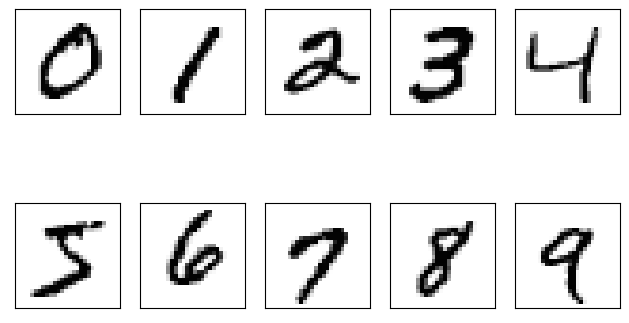

In [3]:
# plot some sample
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    # change to 28x28 image
    img = X[y==i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

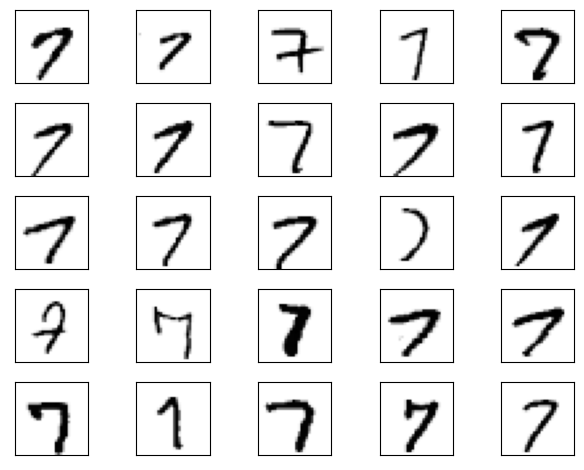

In [4]:
# plot how different samples look for same label
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    # change to 28x28 image
    img = X[y==7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [5]:
# train test set
X_, X_test, y_, y_test = train_test_split(X, y, test_size=10000, random_state=123, stratify=y)

# train val set
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=5000, random_state=123, stratify=y_)


# MLP

In [6]:
# MLP uses sigmoid activation function
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

# function to convert integer class label arrays into on-hot encoded labels
def int_to_onehot(y, num_labels):
    # init all to zero
    array = np.zeros((y.shape[0], num_labels))
    # one-hot encode
    for i, val in enumerate(y):
        array[i, val] = 1
    return array

In [7]:
class NeuralNetMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes
        rng = np.random.RandomState(random_seed)

        # init random weights for hidden layer
        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # init random weights for output layer
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # hidden layer output = X * WT + b
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        # hidden layer activation
        a_h = sigmoid(z_h)

        # output layer output = a_h * WT + b
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        # output layer activation
        a_out = sigmoid(z_out)

        # a_out is the prediction probability, a_h is hidden layer activation output, used for backpropagation
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):
        # encode label into one-hot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # compute delta for output layer
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]
        d_a_out__d_z_out = a_out * (1. - a_out)
        delta_out = d_loss__d_a_out * d_a_out__d_z_out

        d_z_out__dw_out = a_h

        # compute output layer weights and biases gradients
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        d_z_out__a_h = self.weight_out

        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        d_a_h__d_z_h = a_h * (1. - a_h)

        d_z_h__d_w_h = x

        # compute hidden layer weights and biases gradients
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        # return gradients
        return d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h

In [8]:
model = NeuralNetMLP(num_features=28*28, num_hidden=50, num_classes=10)

# Training

In [9]:
# get training data in batches

batch_size = 100

def minibatch_generator(X, y, batch_size):
    # shuffle the indices of training samples
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    # iterate through the entire dataset, at batch_size batches at a time and return
    for start_idx in range(0, indices.shape[0] - batch_size + 1, batch_size):
        batch_idx = indices[start_idx: start_idx + batch_size]
        yield X[batch_idx], y[batch_idx]

In [10]:
# function to compute error (MSE) and accuracy for the whole dataset, computed in batches
def compute_mse_and_acc(model, X, y, num_labels=10, batch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0

    # iterate dataset in batches
    minibatch_gen = minibatch_generator(X, y, batch_size)
    for i, (X_batch, y_batch) in enumerate(minibatch_gen):
        # model predicts class probabilities
        _, probas = model.forward(X_batch)

        # onehot encode the targets
        onehot_y_batch = int_to_onehot(y_batch, num_labels)

        # compute MSE
        epoch_mse = np.mean((onehot_y_batch - probas) ** 2)
        mse += epoch_mse

        # keep track of correct predicts for computing accuracy
        predicted_labels = np.argmax(probas, axis=1)
        correct_pred += (predicted_labels == y_batch).sum()
        num_examples += y_batch.shape[0]

    mse = mse / i
    acc = correct_pred / num_examples
    return mse, acc

In [11]:
def train(model, X_train, y_train, X_val, y_val, num_epochs, learning_rate=0.1):
    # keep track of each epochs metrics
    epoch_loss = []
    epoch_train_acc = []
    epoch_val_acc = []

    for epoch in range(num_epochs):
        # iterate dataset in batches
        minibatch_gen = minibatch_generator(X_train, y_train, batch_size)
        for X_train_batch, y_train_batch in minibatch_gen:
            # forward propagation to outputs
            a_h, a_out = model.forward(X_train_batch)

            # backpropagation to compute gradients for the weights and biases in the output and hidden layer
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = model.backward(X_train_batch, a_h, a_out, y_train_batch)

            # update weights and biases
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        # evaluate this epoch
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        val_mse, val_acc = compute_mse_and_acc(model, X_val, y_val)

        train_acc, val_acc = train_acc * 100, val_acc * 100

        # keep track of all epochs
        epoch_train_acc.append(train_acc)
        epoch_val_acc.append(val_acc)
        epoch_loss.append(train_mse)

        print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} | Train MSE: {train_mse:.2f} | Train Acc: {train_acc:.2f}% | Valid Acc: {val_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_val_acc
            

In [12]:
np.random.seed(123)  # for training set shuffling

epoch_loss, epoch_train_acc, epoch_val_acc = train(model, X_train, y_train, X_val, y_val, num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 76.15% | Valid Acc: 75.98%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 85.45% | Valid Acc: 85.04%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 87.82% | Valid Acc: 87.60%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 89.36% | Valid Acc: 89.28%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.21% | Valid Acc: 90.04%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.67% | Valid Acc: 90.54%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.12% | Valid Acc: 90.82%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.43% | Valid Acc: 91.26%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 91.84% | Valid Acc: 91.50%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.04% | Valid Acc: 91.84%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.30% | Valid Acc: 92.08%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.51% | Valid Acc: 92.24%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.65% | Valid Acc: 92.30%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 92.80

# Evaluation

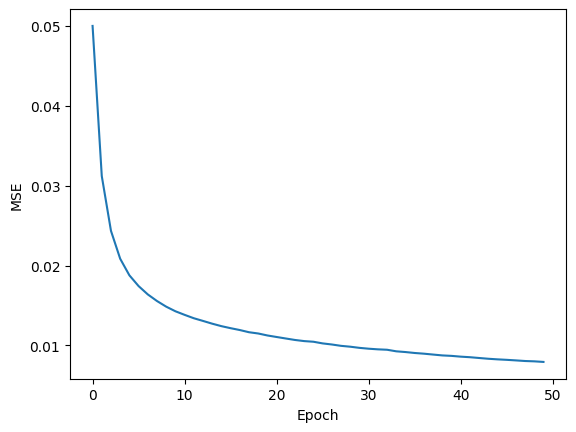

In [13]:
# plot training MSE over epochs
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

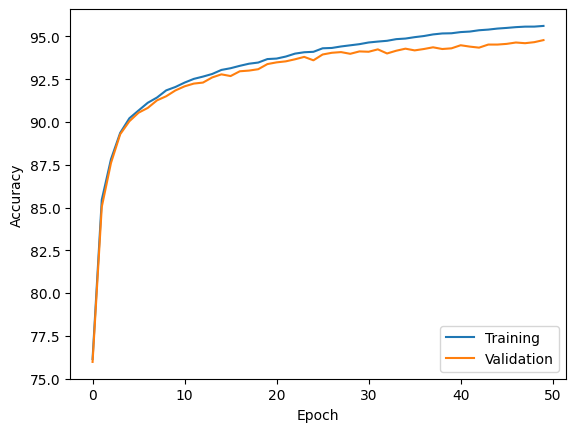

In [14]:
# plot training and validation accuracy over epochs
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
plt.plot(range(len(epoch_val_acc)), epoch_val_acc, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [15]:
# evaluate on the test set
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.54%


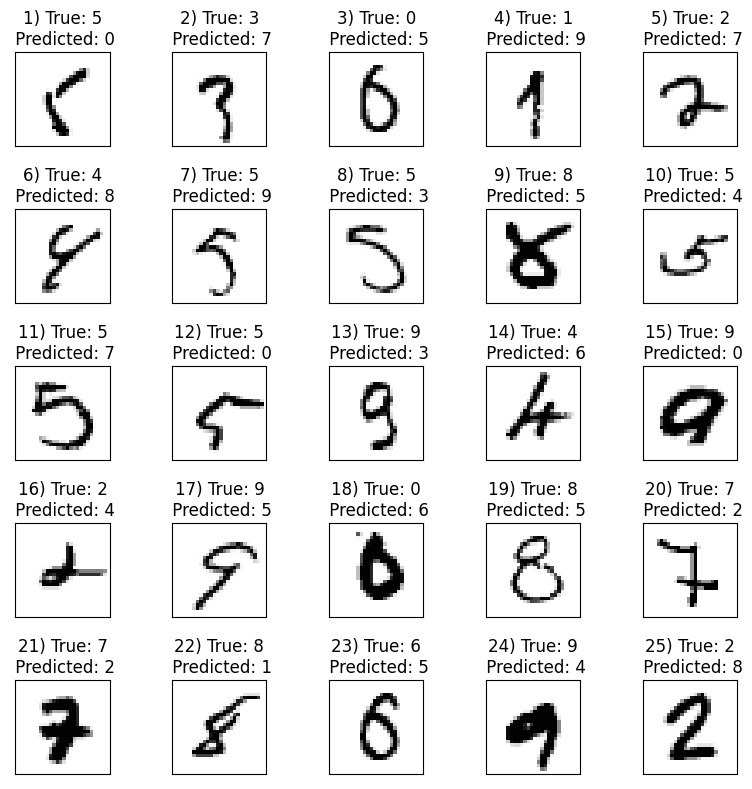

In [17]:
# check some misclassified samples

# predict on a subset
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]
_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

# get some misclassifed samples
misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

# plot
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
    ax[i].set_title(f'{i+1}) True: {correct_labels[i]}\n Predicted: {misclassified_labels[i]}')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()
